In [ ]:
import json
import pathlib

from fastai.text import *

import numpy as np
import pandas as pd

In [ ]:
import spacy
spacy.load('de')

# Data Preparation

In [ ]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH = pathlib.Path("lm/german/data/")

In [ ]:
LM_PATH=Path('lm/german/german_lm/')
LM_PATH.mkdir(exist_ok=True)

In [ ]:
# preprocess wikipedia files (prepare_wikipedia.sh)

In [ ]:
LANG_FILENAMES = [str(f) for f in PATH.rglob("*/*")]
print(len(LANG_FILENAMES))
LANG_FILENAMES[0:5]

In [ ]:
LANG_TEXT = []
for i in LANG_FILENAMES:
    for line in open(i):
        LANG_TEXT.append(json.loads(line))
        
LANG_TEXT = pd.DataFrame(LANG_TEXT)

In [ ]:
LANG_TEXT.to_csv(f"{LM_PATH}/Wiki_German_Corpus.csv", index=False)

In [ ]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_German_Corpus.csv")

In [ ]:
(LANG_TEXT.assign(labels = 0)
    .pipe(lambda x: x[['labels', 'text']])
    .to_csv(f"{LM_PATH}/Wiki_German_Corpus2.csv", header=None, index=False))

# Create Language Model Tokens
Split title from text body and tokenize text using spacy tokenizer (using the 'DE' module for German Language)

In [ ]:
# REmove title name in the text field
def split_title_from_text(text):
    words = text.split("\n\n")
    if len(words) >= 2:
        return ''.join(words[1:])
    else:
        return ''.join(words)
    
LANG_TEXT['text'] = LANG_TEXT['text'].apply(lambda x: split_title_from_text(x))


In [ ]:
# Number of documents
LANG_TEXT.shape

In [ ]:
# number of words in dataset
LANG_TEXT['text'].apply(lambda x: len(x.split(" "))).sum()

In [ ]:
# number of unique tokens
len(set(''.join(LANG_TEXT['text'].values).split(" ")))

In [ ]:
def get_texts(df, n_lbls=1, lang='de'):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    #texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer(lang=lang).proc_all_mp(partition_by_cores(texts)) # splits the list into sublists for processing by each core
    # Lower and upper case is inside the tokenizer
    return tok, list(labels)

def get_all(df, n_lbls, lang='de'):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        #pdb.set_trace()
        tok_, labels_ = get_texts(r, n_lbls, lang=lang)
        tok += tok_;
        labels += labels_
    return tok, labels

In [ ]:
LANG_TEXT = pd.read_csv(f"{LM_PATH}/Wiki_German_Corpus2.csv", header=None)#, chunksize=5000)

In [ ]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    LANG_TEXT, test_size=0.1) # split the data into train and validation sets

We split our corpus into train and validation set and shuffle it 

In [ ]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts)) # generate a random ordering
val_idx = np.random.permutation(len(val_texts))

df_trn = trn_texts.iloc[trn_idx,:] # sort things randomly
df_val = val_texts.iloc[val_idx,:] # sort things randomly

df_trn.columns = ['labels', 'text']
df_val.columns = ['labels', 'text']

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False) # saving the data in our new format to disk

In [ ]:
# read train and test data
chunksize = 10000
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [ ]:
#perform tokenization
tok_trn, trn_labels = get_all(df_trn, 1, lang='de')
tok_val, val_labels = get_all(df_val, 1, lang='de')

In [ ]:
# create a tmp directory to store the upcoming numpy arrays
(LM_PATH/'tmp').mkdir(exist_ok=True)

# save the train and validation tokens in the tmp directories
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [ ]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [ ]:
# Identify the most common tokens and numericalizing the text
freq = Counter(p for o in tok_trn for p in o) 
freq.most_common(500)

The vocab represents the unique set of all tokens (i.e. words) in our dataset.  
We ignore rare words and set max_vocab to 60000.

In [ ]:
# Truncating our vocab to ignore the rare words
max_vocab = 60000
min_freq = 5

itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq] # getting rid of the rare words
itos.insert(0, '_pad_') # 
itos.insert(0, '_unk_') # itos is the list of all the strings in the vocab

stoi is a reverse mapping for our tokens to it's index (look-up index for a given word)

In [40]:
# creating a index-key dictionary for our vocabulary
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [ ]:
# creating a index representation for our train and validation dataset
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
# saving our indexed representation of our dataset to disk
# we also save the index-word mapping to retrieve the complete text representation from these numpy arrays
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [41]:
# Loading the indexed representation of our dataset from disk
# we also load the index-word mapping to to help us convert the indexes to word datasets, if need be.
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [ ]:
# checking vocabulary size
vs=len(itos)
vs,len(trn_lm)

# Model setup
Set embedding size to 400, 1150 hidden untis and 3 layers.

In [ ]:
em_sz, nh, nl = 400, 1150, 3

# Language Model
We build a backbone Language Model from German Wikipedia data (fixed batch size) 

In [ ]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

We concatenate all tokens and pass them to LanguageModelLoader 

In [ ]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
# return the language model itself
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. No other dropout value requires tuning

In [ ]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7 # if you're overfitting, increase this. Underfitting? decrease this.

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.
We also keep track of the accuracy metric.

In [ ]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.clip = 0.2
learner.unfreeze()
#learner.freeze_to(-1)

In [ ]:
lr=1e-3
lrs = lr

In [ ]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) # train emneddings

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.
The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [ ]:
learner.save('lm_last_ft')

learner.save_encoder('lm_last_enc')
learner.unfreeze()

In [ ]:
learner.load('lm_last_ft')
# find good learning rate
#learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [ ]:
#learner.sched.plot()

In [ ]:
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [ ]:
#learner.save('lm1')
#learner.save_encoder('lm1_enc')
#learner.sched.plot_loss()

In [ ]:
# I did not run this because I currently do not have access to a GPU (long runtime)
#learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)
#learner.save('lm2')
#learner.save_encoder('lm2_enc')

# Extract Embeddings from Language Model
The following code can be used to extract the embeddings from the language model

In [ ]:
learner.load('lm_last_ft')
m = learner.model
m.eval()
layers = list(m.children())
dir(layers[0].encoder)
layers[0].encoder.weight

# Test predictions on Language Model

In [ ]:
learner.load('lm_last_ft')
m = learner.model
m.eval()

In [ ]:
sen = "ich stehe in"
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
idxs

In [ ]:
p = m(VV(idxs))
type(p), len(p)

In [ ]:
p[0].shape, [x.shape for x in p[1]], [x.shape for x in p[2]]

In [ ]:
#p[0] is most likely the output vector
p[0].data

In [ ]:
# This command gives us the index of the word which has the highest probability for the last row
torch.topk(p[0][-1], 1)

In [ ]:
#predict the next word
itos[torch.topk(p[0][-1], 1)[1].data[0]]

In [ ]:
def get_next(inp):
#     m[0].bs = 1 ## why?
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #pdb.set_trace()
    i = np.argmax(to_np(p)[0], 1)[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r

def get_next(inp):
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    p = m(VV(idxs))
    #i = np.argmax(to_np(p)[0], 1)[0]
    i = torch.topk(p[0][-1], 1)[1].data[0]
    try:
        r = itos[i]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        print("input: [", inp, "] ||| c:[", c, "]")
        #pdb.set_trace()
        # res += c # ???
        res = res + " " + c
        #pdb.set_trace()
#         inp = ' '.join(inp.strip().split(" ")[1:]) + "  " + c
        inp = inp + " " + c
        inp = ' '.join(inp.strip().split(" ")[-5:]) + "  " + c
        
    return res

In [ ]:
sen = "ich wohne in"

# o = get_next(sen)
o = get_next_n(sen, 10)
print(o)

In [ ]:
# more intereference tests
def get_next(inp):
    m[0].bs =1
    #print(inp)
    idxs = np.array([[stoi[p] for p in inp.strip().split(" ")]])
    probs = m(VV(idxs))
    encc = probs[-1][-1][-1][-1].squeeze()
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    try:
        r = itos[pred]
    except:
        r = "oor"
    return r


def get_next_n(inp, n):
    res = inp
    for i in range(n):
        c = get_next(inp)
        # res += c # ???
        res = res + " " + c
        #print(res)
        inp = inp.strip().split(" ") + [c]        
#         inp = ' '.join(inp[1:])
        inp = ' '.join(inp)
        
    return res

In [ ]:
sen = "der sieger spielt gegen" 
get_next_n(sen, 10)

# Classifier Tokens
The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [ ]:
CLAS_PATH = Path("lm/german/german_twitter_clas/")
LM_PATH.mkdir(exist_ok=True)

In [ ]:
df_clas_data = pd.read_csv(CLAS_PATH/"downloaded.tsv", sep="\t", header=None)
df_clas_data = df_clas_data[[1,4]]
df_clas_data.columns = ['sentiment', 'tweet_text']

df_clas_data.applymap(lambda x: x.strip() if type(x) is str else x)
df_clas_data = df_clas_data[df_clas_data.tweet_text.str.contains("Not Available") == False]

mapping = {'positive': -1.0, 'negative': 1.0, 'neutral': 0}
df_clas_data = df_clas_data.replace({'sentiment': mapping})
#df_clas_data['sentiment'] = df_clas_data['sentiment'].str.strip()
df_clas_data['sentiment'] = df_clas_data['sentiment'].astype(np.float32)

In [ ]:
# copy-past from https://github.com/abdulfatir/twitter-sentiment-analysis/blob/master/preprocess.py
import re

import re
import sys


def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word


def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USER_MENTION', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        if is_valid_word(word):
            processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [ ]:
df_clas_data['tweet_text'] = df_clas_data['tweet_text'].apply(lambda x: preprocess_tweet(x))

In [ ]:
#remove neutral comments
#df_clas_data = df_clas_data[df_clas_data['sentiment'] != 0].reset_index(drop=True)

df_clas_data.to_csv(CLAS_PATH/"German_Sentiment_Data.csv", index=False)

# Creating train and validation sets
np.random.seed(42)
trn_keep = np.random.rand(len(df_clas_data))>0.1
df_trn = df_clas_data[trn_keep]
df_val = df_clas_data[~trn_keep]

# Saving train and validation sets to disk
df_trn.to_csv(CLAS_PATH/"German_Sentiment_Data_Train.csv", header=None, index=False)
df_val.to_csv(CLAS_PATH/"German_Sentiment_Data_Test.csv", header=None, index=False)

len(df_trn),len(df_val)

In [ ]:
#Number of tweets per sentiment
df_clas_data['sentiment'].value_counts()

In [ ]:
chunksize = 10000
df_trn = pd.read_csv(CLAS_PATH/"German_Sentiment_Data_Train.csv", header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/"German_Sentiment_Data_Test.csv", header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [ ]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

# Classifier
We build a classifier to predict sentiment of Twitter messages using the Language Model trained on German Wikipedia data.

In [1]:
from fastai.text import * 
import json
import pathlib


import numpy as np
import pandas as pd

PATH = pathlib.Path("lm/german/data/")

LM_PATH=Path('lm/german/german_lm/')
LM_PATH.mkdir(exist_ok=True)
CLAS_PATH = Path("lm/german/german_twitter_clas/")
LM_PATH.mkdir(exist_ok=True)
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [2]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [3]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [4]:
#length of first comment
len(trn_clas[0])

21

In [5]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [6]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1


In [7]:
c

3

We need to classify the sentiment of the data into either positive / neutral / negative (number of classes c = 3).

In [8]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [9]:
 dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [10]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [11]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [16]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [17]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [18]:
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [19]:
wd = 1e-7
wd = 0
learn.load_encoder('lm_last_enc')

In [20]:
learn.freeze_to(-1)

 81%|████████  | 215/266 [03:07<00:44,  1.15it/s, loss=4.01] 

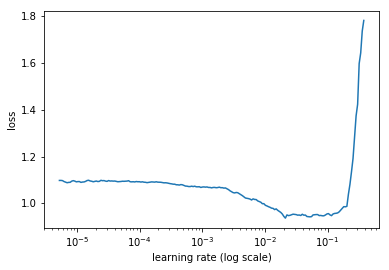

In [21]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [22]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.835341   0.812058   0.637385  


[array([0.81206]), 0.6373851706036746]

In [23]:
learn.save('clas_0')
learn.save_encoder('clas_0_enc')

In [24]:
learn.load('clas_0')

In [25]:
learn.freeze_to(-2)

In [26]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                    
    0      0.819445   0.795983   0.652067  


[array([0.79598]), 0.6520669291338582]

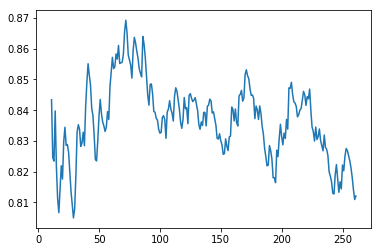

In [27]:
learn.sched.plot_loss()

In [28]:
learn.save('clas_1')

In [29]:
learn.load('clas_1')

In [30]:
learn.unfreeze()

In [ ]:
#learn.fit(lrs, 1, wds=wd, cycle_len=15, use_clr=(32,10))
learn.fit(lrs, 1, wds=wd, cycle_len=15, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                    
    0      0.827535   0.791584   0.661745  
    1      0.787952   0.755939   0.669455                    
    2      0.814609   0.754204   0.679216                    
    3      0.773758   0.75419    0.671998                    
    4      0.736103   0.742018   0.685367                    
    5      0.696975   0.755873   0.67897                     
    6      0.62995    0.760091   0.690453                    
    7      0.613698   0.822833   0.665682                    
 17%|█▋        | 46/266 [01:31<07:15,  1.98s/it, loss=0.59] 

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('clas_2')

# Experiments
For validation purposes, we try to manually get predictions from the classifier

In [ ]:
#get predictions from evaluation set
pred_pred = learn.predict()

In [ ]:
pred = Variable(torch.from_numpy(pred_pred))

In [ ]:
#convert prediction into probababilities
prob = F.softmax(pred)
print(prob)

In [ ]:
m

In [ ]:
# perform manual prediction on the validation set 
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')
learn.load('clas_2')
m = learn.model
#set batch size to 1
m[0].bs=1
#turn off dropout
i = 0
results = []
while i < len(tok_val):
    #print(i)
    sen = ' '.join(tok_val[i])
    i+=1
    m.eval()
    #reset hidden state
    m.reset()
    idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])
    idxs = np.transpose(idxs)
    #get predictions from model
    p = m(VV(idxs))
    print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))
    # append classification to list of results for validation
    results.append(torch.topk(p[0],1)[1].data.tolist()[0])

In [ ]:
# single prediction
learn.load('clas_2')
m = learn.model
#set batch size to 1
m[0].bs=1
#turn off dropout
m.eval()
#reset hidden state
m.reset()  

#sentence to be classified
sen = "guten morgen schon novemberlicht da mag man gar nicht glauben was gestern wetter war"
idxs = np.array([[stoi[p] for p in sen.strip().split(" ")]])

#converting sentence into numerical representation
print('numeric representation: ' + str(idxs))
idxs = np.transpose(idxs)

#get predictions from model
p = m(VV(idxs))
print(sen + ': ' + str(to_np(torch.topk(p[0],1)[1])[0]))

In [ ]:
# val_labels are the labels from the dataset
print(len(val_labels))
# results are the predicted results
print(len(results))

In [ ]:
preds = np.asarray(results)

In [ ]:
from sklearn.metrics import *
# f1 score for all three classes
f1_score(val_labels, preds, average='weighted')

In [ ]:
print(classification_report(val_labels, preds))

In [ ]:
print(confusion_matrix(val_labels, preds))